# Laboratorio 1 - Regresión

### Integrantes

1. Cesar Avellaneda, 202214746, c.avellanedac@uniandes.edu.co.
2. Santiago Tinjaca, 202215991, s.tinjaca@uniandes.edu.co.
3. Jorge Bustamante,


Este notebook tiene los siguientes elementos: 
1. Cargue de los datos.

2. Entendimiento de los datos: Describir las características más relevantes de los datos y todo el perfilamiento de datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.

3. Preparación de datos: Solucionar los problemas de calidad de datos previamente identificados que afecten el modelo a construir. Además, debe aplicar todos los proceso de preprocesamiento de datos necesarios para la construcción del modelo de regresión.

4. Modelado: Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.

5. Evaluación cuantitativa: A partir de las métricas seleccionadas para evaluar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo. Contestar a la pregunta: ¿Su equipo recomienda utilizar en producción el modelo de regresión para estimar los tiempos? ¿Por qué? En caso de no recomendar el uso del modelo, ¿qué recomendaciones haría para continuar iterando con el objetivo de la construcción de un mejor modelo?

6. Evaluación cualitativa: Debe estar compuesta de dos partes:
- Validación de supuestos: Realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.
- Interpretación de los coeficientes: Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y cómo afectan la variable objetivo.

### Entendimiento del negocio:
El caso de estudio es de un hospital que haciendo uso de la metodología KTAS quiere solicitar un modelo que pueda pronosticar el tiempo de duración de una persona en el hospital con base en sus condiciones de llegada.
### Enfoque Analítico:
En este laboratorio vamos a hacer un modelo predictivo usando un aprendizaje supervisado y un modelo de regresión lineal para hacer uso de las condiciones de llegada de los pacientes y predecir la duración de su estancia en el hospital en minutos.

## 1. Carga de los datos

In [342]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import scipy.optimize as optimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import contractions
import re, string, unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer



In [343]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [344]:
datos.shape

(1000, 23)

In [345]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [346]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
839,2,1,16,3,2,"ocular pain, Lt.",1,1,5,100.00,...,36.60,98.00,4,Contusion of eyelid and periocular area,1,4,0,184,"2,00",0
436,2,2,39,4,1,Confusion state,3,0,#BOÞ!,80.00,...,36.80,86.00,2,Hepatorenal syndrome,2,2,0,518,"5,00",0
789,1,2,77,3,1,abd pain,1,1,7,135.00,...,36.70,NaN,3,Advanced gastric cancer,1,3,0,303,"12,58",0
999,1,2,29,3,1,"pain, abdominal",1,1,6,137.00,...,37.60,NaN,3,Allergic reaction,1,3,0,116,"5,97",0
605,2,2,65,2,1,mental change,1,0,#BOÞ!,120.00,...,36.00,98.00,2,Cerebral infarction due to embolism of middle ...,2,2,0,237,"4,00",0


## 2. Entendimiento de los datos

Se nos proporcionaron dos CSV, uno para entrenar el modelo y otro para probarlo, al analizar los datos dados en el CSV de entrenamiento seguimos los siguientes pasos:

In [347]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,983.00,979.00,988.00,985.00,989.00,444.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,1.45,1.51,53.89,2.81,1.20,1.10,0.56,133.49,79.57,84.40,19.45,36.56,97.05,3.33,1.61,3.26,0.57,12792.48,0.25
std,0.50,0.50,19.83,0.80,0.40,0.43,0.50,27.16,15.17,16.30,2.07,0.52,4.76,0.86,1.16,0.87,1.59,87721.15,0.63
min,1.00,1.00,16.00,1.00,1.00,1.00,0.00,50.00,31.00,32.00,14.00,35.00,20.00,1.00,1.00,1.00,0.00,0.00,0.00
25%,1.00,1.00,36.00,2.00,1.00,1.00,0.00,114.00,70.00,73.00,18.00,36.20,97.00,3.00,1.00,3.00,0.00,132.75,0.00
50%,1.00,2.00,56.00,3.00,1.00,1.00,1.00,130.00,80.00,82.00,20.00,36.50,98.00,3.00,1.00,3.00,0.00,270.50,0.00
75%,2.00,2.00,70.25,3.00,1.00,1.00,1.00,150.00,90.00,96.00,20.00,36.80,99.00,4.00,2.00,4.00,0.00,620.00,0.00
max,2.00,2.00,94.00,7.00,2.00,4.00,1.00,275.00,160.00,148.00,30.00,39.80,100.00,5.00,7.00,5.00,9.00,709510.00,2.00


En el CSV hay datos de 1000 pacientes, con 23 características independientes.

Se puede ver que un 75% de los valores de la variable objetivo "Duracion_Estancia_Min" están sobre los 620 minutos (10 horas y 20 minutos), sin embargo, hay datos que alcanzan hasta los 709,510 minutos (1 año y 127 días).

Al ver los atributos de cada una de las filas agrupamos las características de la siguiente manera.

| Category |Fields|
|----------|------|
| Demografía |Sexo, Edad, Grupo|
| Accidente |Modo Llegada, Lesión, Queja, Principal|
| Signos Vitales |Estado Mental, SBP, DBP, HR, RR, BT, Saturación, Dolor|
| Diagnósticos |dolor NRS, KTAS enfermera, Diagnóstico En Urgencias, Disposición, KTAS experto, Duración_Estancia_Min, Duración_KTAS_Min, Error_Triaje|

Lo que nos dice es que una fila de los datos que tiene información de un paciente se compone de su demografía, accidente, los signos vitales y el diagnóstico que le dio en el ala de urgencias.
Entré las características más relevantes se encuentran:
- Los signos vitales: Estado mental, presión Arterial Sistólica, Presión Arterial Diastólica, Frecuencia cardíaca, Frecuencia Respiratoria, Temperatura Corporal y Saturación de Oxígeno.
- La edad de los pacientes.
- El Triaje realizado por la enfermera y los expertos.
- El modo en el que llevan al hospital.

Se realiza un análisis de completitud en el que podemos ver que todos los datos están completos, cuentan con 1000 registros, menos los signos vitales. El más destacado es la saturación, que un 50% de los datos no cuenta con este valor. El resto de los signos vitales no supera el 20% de faltantes. Creemos que la toma de estos signos está relacionada con la gravedad del estado del paciente.

In [348]:
datos.isnull().sum() / datos.shape[0]

Grupo                      0.00
Sexo                       0.00
Edad                       0.00
Modo_Llegada               0.00
Lesion                     0.00
Queja_Principal            0.00
Estado_Mental              0.00
Dolor                      0.00
dolor_NRS                  0.00
SBP                        0.02
DBP                        0.02
HR                         0.01
RR                         0.01
BT                         0.01
Saturacion                 0.56
KTAS_enfermera             0.00
Diagnostico_En_Urgencias   0.00
Disposicion                0.00
KTAS_experto               0.00
Grupo_De_Error             0.00
Duracion_Estancia_Min      0.00
Duracion_KTAS_Min          0.00
Error_Triaje               0.00
dtype: float64

Los datos de la variable dolor_NRS están completos, no hay nulos, pero casi el 44% de los datos está marcado con #BOÞ!.

In [349]:
datos["dolor_NRS"].value_counts()/datos.shape[0]

dolor_NRS
#BOÞ!   0.44
3       0.21
4       0.11
5       0.11
6       0.06
2       0.03
7       0.03
8       0.01
10      0.00
1       0.00
9       0.00
Name: count, dtype: float64

La Duracion_KTAS_Min se encuentra guardada como object y no como float64. Se decide realizar este cambio para poder continuar con el entendimiento de los datos.

In [350]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

Para fines prácticos se extrae en una lista todas las variables numéricas que se pueden procesar.

In [351]:
numericas = ["Grupo", "Sexo", "Edad",  "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor","KTAS_enfermera", "SBP", "DBP", "HR", "RR", "BT", "Saturacion", "Disposicion", "KTAS_experto", "Duracion_KTAS_Min", "Duracion_Estancia_Min"]

Dado que existen una gran brecha entre la duración de la estancia, que el 75% está por debajo de 700 y después de esos se dispara, tomamos la decisión de no contar con esos datos para poder seguir con el entendimiento. Como se puede ver a continuación. Los datos crecen de forma razonable hasta cierto punto.

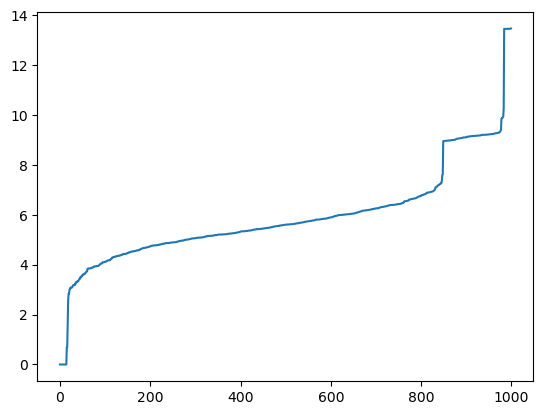

In [352]:
plt.plot(np.log(np.sort(datos["Duracion_Estancia_Min"]+1)))

<Axes: ylabel='Duracion_Estancia_Min'>

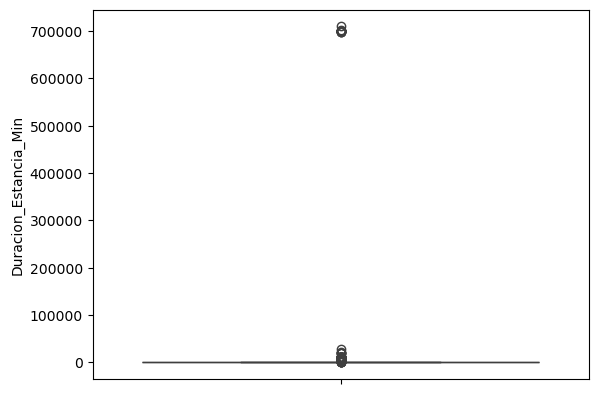

In [353]:
sns.boxplot(datos["Duracion_Estancia_Min"])

Para continuar con el entendimiento se decide tomar el percentil 0.8 de los datos, lo que equivale a todas las filas que el tiempo de su estancia sea menor a 858 minutos, lo que nos da unos datos menos dispersos y manejables. 

(800, 23)
858.0000000000002


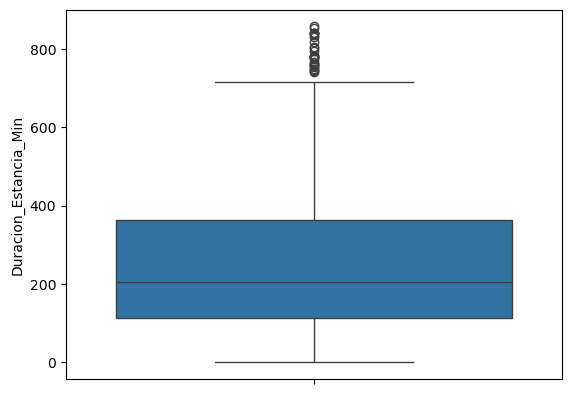

In [354]:
val = datos["Duracion_Estancia_Min"].quantile(0.8)
datos_recorte =datos[datos["Duracion_Estancia_Min"]<=val]
sns.boxplot(datos_recorte["Duracion_Estancia_Min"])
print(datos_recorte.shape)
print(val)

Realizamos una gráfica scatter por cada variable numérica para tratar de ver tendencias de comportamiento de los datos.

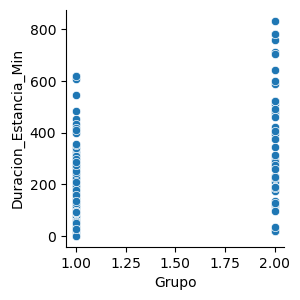

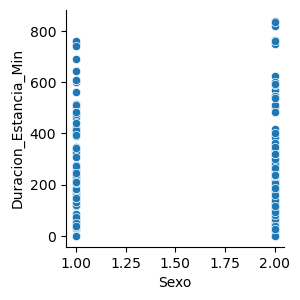

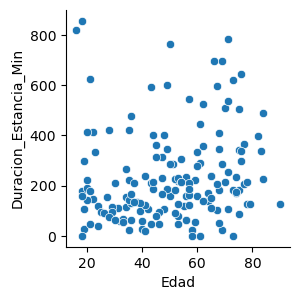

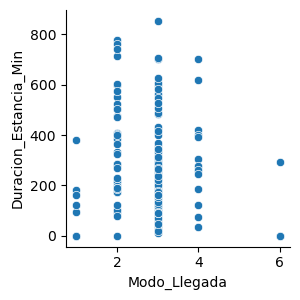

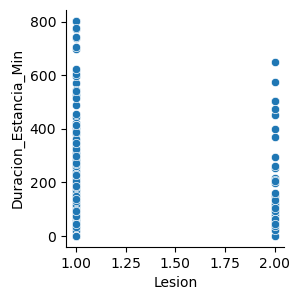

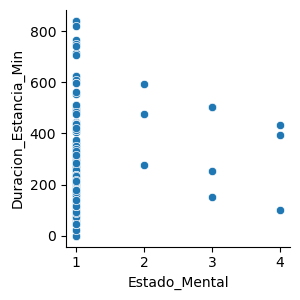

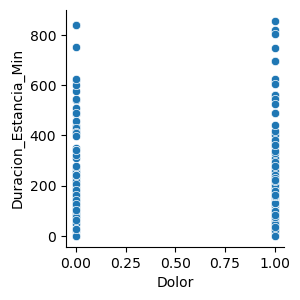

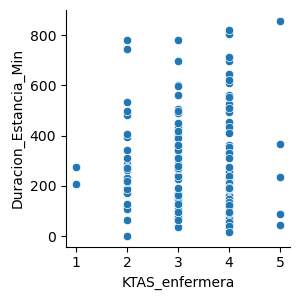

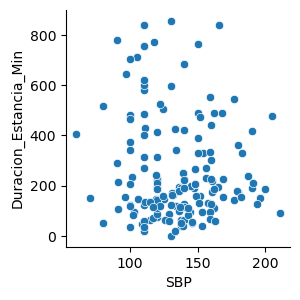

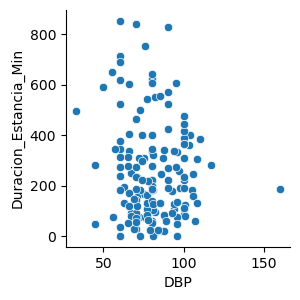

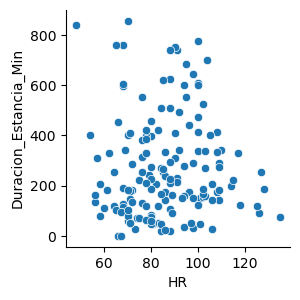

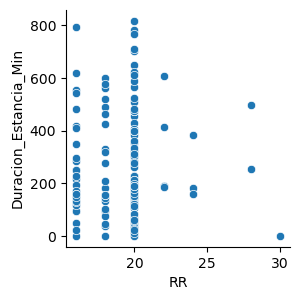

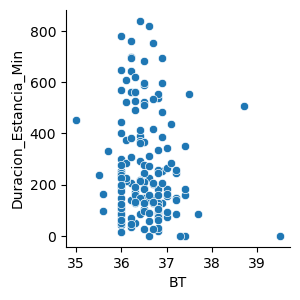

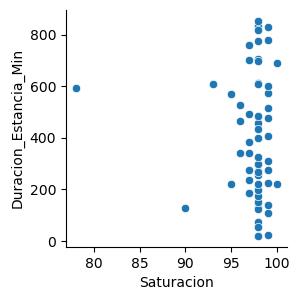

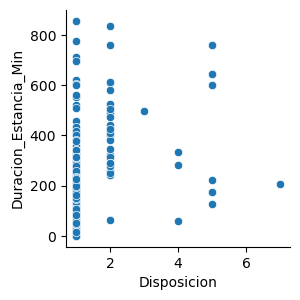

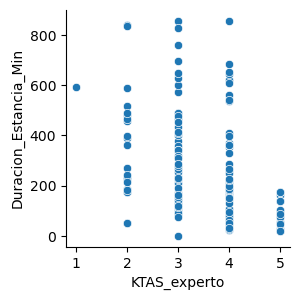

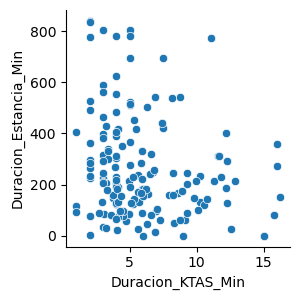

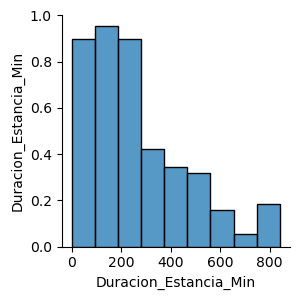

In [355]:
for variable in numericas:
    sns.pairplot(datos_recorte.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

Lo más notable de estos gráficos y que usaremos luego, es una posible distribución logarítmica normal de la variable de Duracion_KTAS_Min contra Duracion_Estancia_Min.

Probamos con todos los datos y su relación con la variable objetivo, se puede apreciar que ninguna de las variables, obviando "Grupo", superan el 5% de coeficiente de correlación.

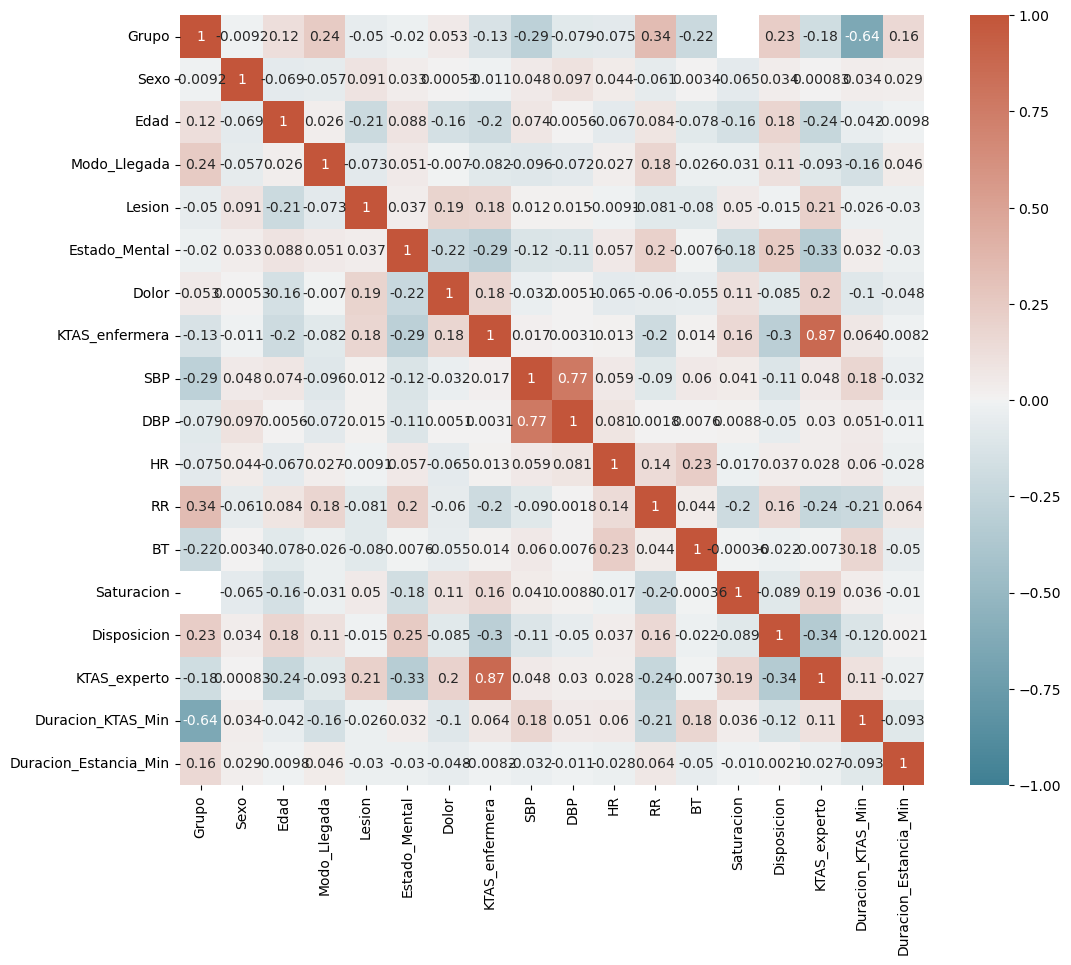

In [356]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

Ahora, haciendo uso del recorte, las correlaciones aumentan significativamente, sin embargo, siguen habiendo correlaciones bastante poco significativas (no superiores al 25%).

Las variables que más relaciones tienen son Grupo: 40%, Lesion: 16%, KTAS_experto: 24%, edad: 21%, la disposicion: 18% y la duración del KTAS: 20%. Los signos vitales son muy dispersos y podemos optar por unirlos.

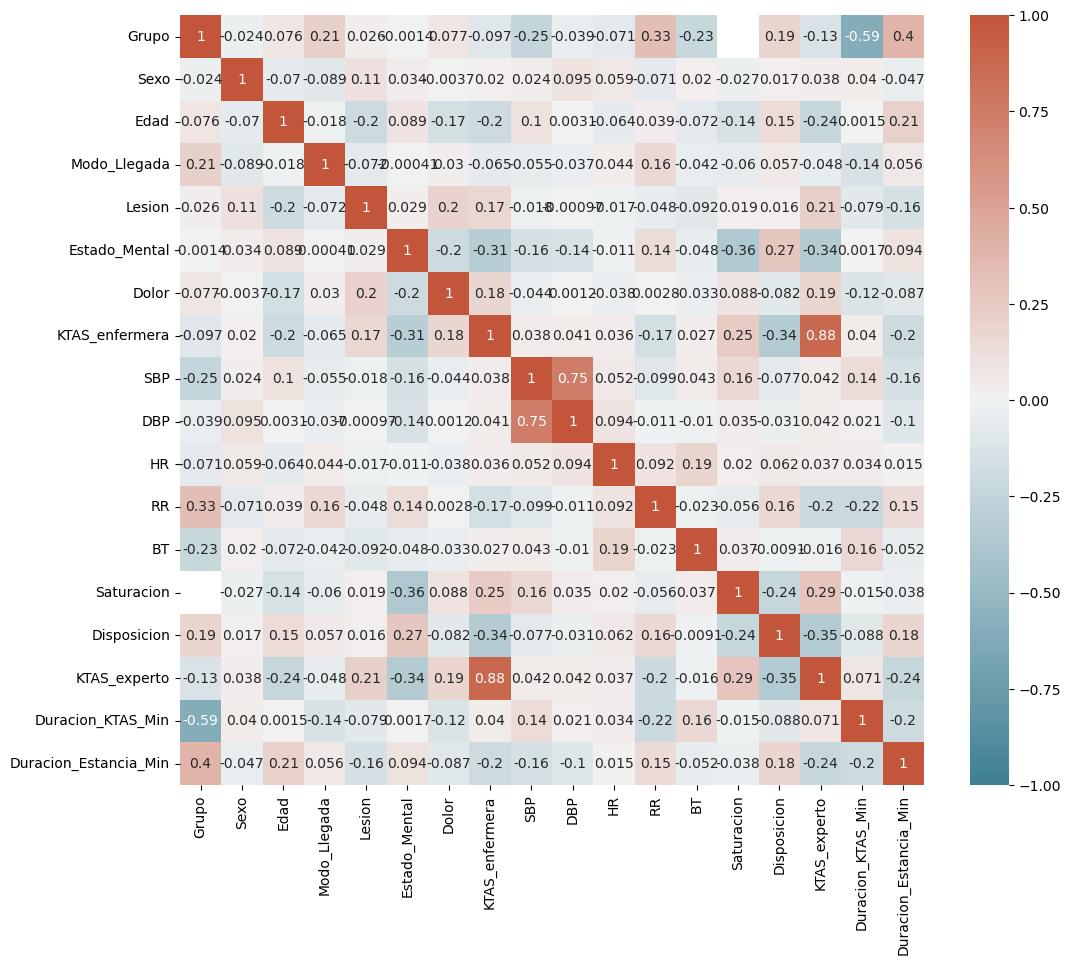

In [357]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos_recorte[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

En la preselección de los datos elegimos las variables más relevantes con relación a la objetivo.

In [358]:
candidatas = ["Grupo", "Lesion","KTAS_experto","Disposicion",  "Edad", "Duracion_KTAS_Min"]


## 3. Preparación de datos

Problemas de calidad:

Primero el dolor reportado por la enfermera, el cual tiene un 44% de sus entradas en null.
Nos dimos cuenta de que estas se correspondían cuando el paciente no tenía dolor, por lo que las asignamos a 0. Esto tenía una excepción en 2 entradas, las cuales registraban que el paciente tenía dolor, pero no especificaba cuál, por lo que le asignamos la media.

In [359]:
def calida_dolor_NRS(registro):
    if registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] == 0:
        return 0
    elif registro["dolor_NRS"] == "#BOÞ!" and registro["Dolor"] != 0:
        return registro["dolor_NRS"]
    return int(registro["dolor_NRS"])
datos['dolor_NRS'] = datos.apply(calida_dolor_NRS, axis=1)

mean = datos[datos["dolor_NRS"] != "#BOÞ!" ]['dolor_NRS'].mean()
datos["dolor_NRS"] = datos["dolor_NRS"].apply(lambda x: round(mean) if x == "#BOÞ!" else x)
datos["dolor_NRS"].value_counts()

dolor_NRS
0     438
3     209
4     111
5     109
6      59
2      33
7      27
8       8
10      3
1       2
9       1
Name: count, dtype: int64

Después usamos la técnica del One-Hot, para estandarizar el Sexo y la Lesión.

In [360]:
datos["Sexo_stan"] = datos["Sexo"].apply(lambda x: 0 if x == 2 else x)
datos["Sexo_stan"].value_counts()

Sexo_stan
0    514
1    486
Name: count, dtype: int64

In [361]:
datos["Lesion_stan"]=datos["Lesion"].apply(lambda x:0 if x == 2 else x)
datos["Lesion_stan"].value_counts()

Lesion_stan
1    800
0    200
Name: count, dtype: int64

Hicimos una investigación para agrupar los signos vitales en esta y llegamos al Early Warning Score (EWS) es una herramienta clínica utilizada para identificar a los pacientes que están en riesgo de deterioro. El cálculo del EWS generalmente se basa en una serie de parámetros fisiológicos como la frecuencia cardíaca, la presión arterial, la temperatura, la frecuencia respiratoria, y el nivel de conciencia, la calculamos y la agregamos a los datos.

In [362]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro.get('RR', np.nan) <= 8:
        total += 2
    elif 9 <= registro.get('RR', np.nan) <= 14:
        total += 0
    elif 15 <= registro.get('RR', np.nan) <= 20:
        total += 1
    elif 21 <= registro.get('RR', np.nan) <= 29:
        total += 2
    elif registro.get('RR', np.nan) >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro.get('SBP', np.nan) <= 70:
        total += 3
    elif 71 <= registro.get('SBP', np.nan) <= 80:
        total += 2
    elif 81 <= registro.get('SBP', np.nan) <= 100:
        total += 1
    elif 101 <= registro.get('SBP', np.nan) <= 199:
        total += 0
    elif registro.get('SBP', np.nan) >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro.get('HR', np.nan) <= 40:
        total += 2
    elif 41 <= registro.get('HR', np.nan) <= 50:
        total += 1
    elif 51 <= registro.get('HR', np.nan) <= 100:
        total += 0
    elif 101 <= registro.get('HR', np.nan) <= 110:
        total += 1
    elif 111 <= registro.get('HR', np.nan) <= 129:
        total += 2
    elif registro.get('HR', np.nan) >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro.get('BT', np.nan) < 35.0:
        total += 2
    elif 35.0 <= registro.get('BT', np.nan) <= 38.4:
        total += 0
    elif registro.get('BT', np.nan) >= 38.5:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro.get('Saturacion', np.nan) <= 91:
        total += 3
    elif 92 <= registro.get('Saturacion', np.nan) <= 93:
        total += 2
    elif 94 <= registro.get('Saturacion', np.nan) <= 95:
        total += 1

    # Nivel de conciencia
    if registro.get('Estado_Mental', np.nan) == 1:
        total += 0
    elif registro.get('Estado_Mental', np.nan) == 2:
        total += 1
    elif registro.get('Estado_Mental', np.nan) == 3:
        total += 2
    elif registro.get('Estado_Mental', np.nan) == 4:
        total += 3

    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
datos.head()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,Sexo_stan,Lesion_stan,EWS
0,2,2,49,2,1,ant. chest pain,1,1,2,150.00,...,Ischaemic chest pain,2,2,0,1591,2.00,0,0,1,1
1,2,2,30,4,1,headache,1,1,4,140.00,...,"Subarachnoid haemorrhage, unspecified",7,3,0,211,3.00,0,0,1,1
2,2,1,61,3,2,ant. chest pain,1,1,3,100.00,...,Contusion of front wall of thorax,1,4,0,119,2.00,0,1,0,2
3,2,2,61,3,1,headache,1,1,4,120.00,...,Headache,1,3,4,414,2.00,2,0,1,1
4,1,2,67,3,1,fever & chill,1,0,0,143.00,...,Fever,1,2,1,267,3.60,2,0,1,4


Por último, intentamos linealizar la "Duracion_KTAS_Min".

In [363]:
datos["Dur_KTAS_lin"] = np.log(datos["Duracion_KTAS_Min"])

In [364]:
numericas = ["Grupo", "Sexo", "Edad",  "Modo_Llegada", "Lesion","Lesion_stan", "Estado_Mental", "Dolor","KTAS_enfermera", "EWS", "Disposicion", "KTAS_experto", "Duracion_KTAS_Min","Dur_KTAS_lin", "Duracion_Estancia_Min"]

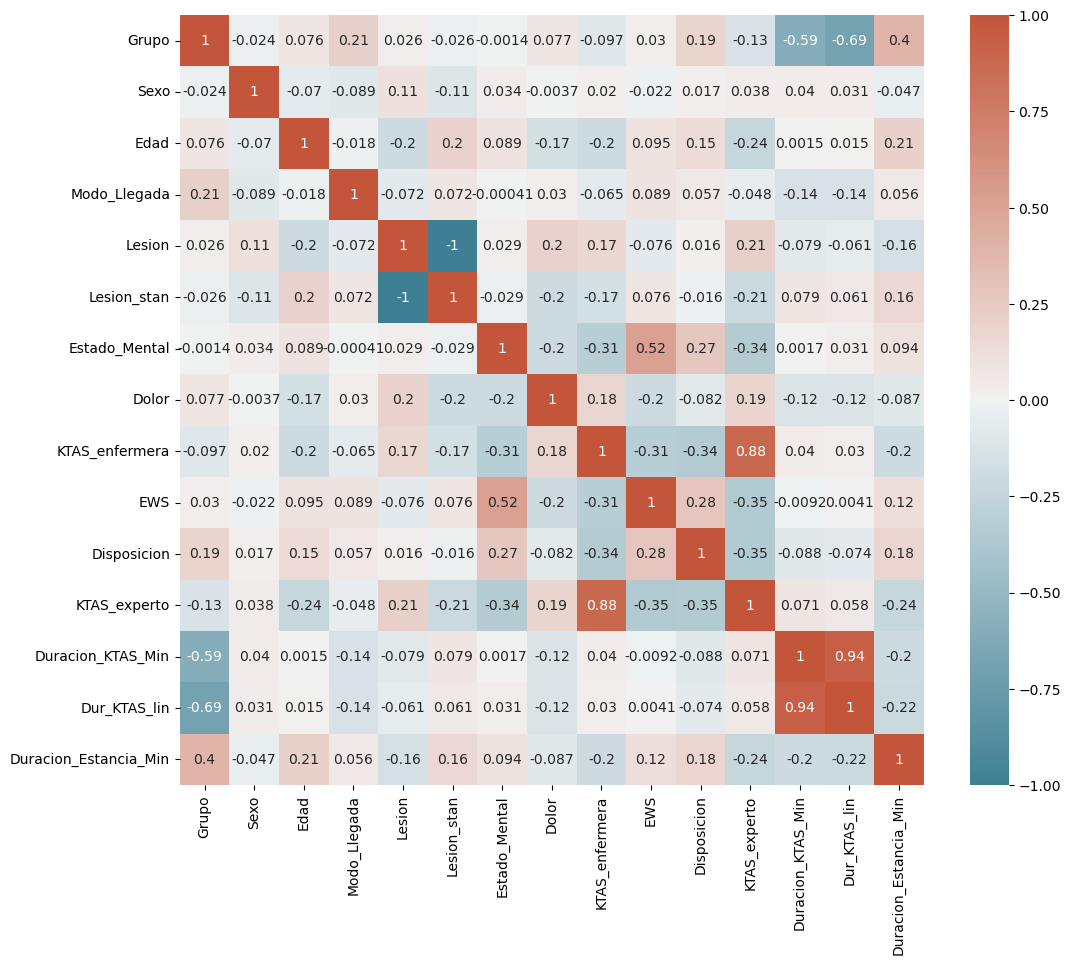

In [365]:
val = datos["Duracion_Estancia_Min"].quantile(0.8)
datos_recorte =datos[datos["Duracion_Estancia_Min"]<=val]
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos_recorte[numericas].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

Usando este nuevo heatmap tenemos las siguientes variables candidatas.

In [366]:
candidatas = ["Grupo", 
              "Edad", 
              "Disposicion",
              "Lesion_stan",
              "KTAS_experto",
              "EWS",
              "Duracion_KTAS_Min"]

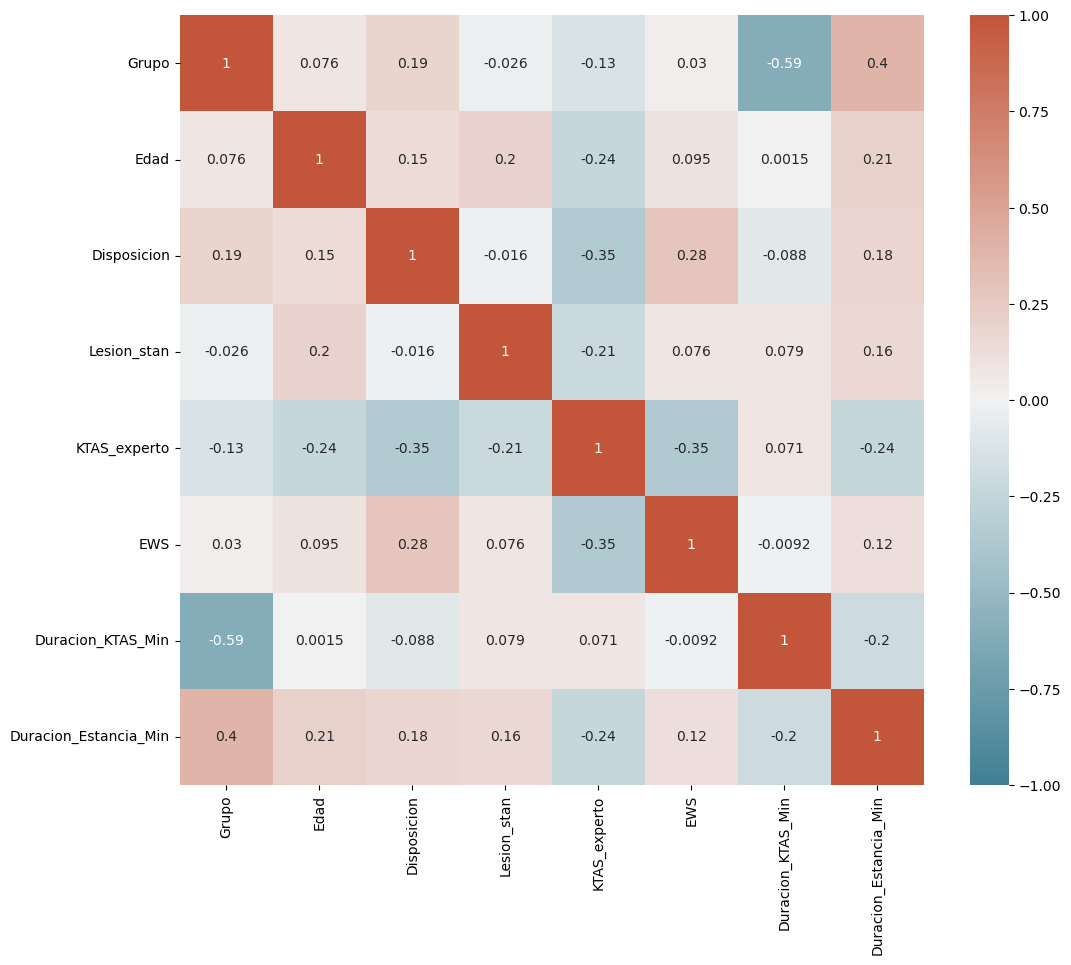

In [367]:
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    datos_recorte[candidatas+["Duracion_Estancia_Min"]].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)
plt.show()

Hacemos una limpieza de duplicados:

In [368]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [369]:
datos.shape

(1000, 27)

In [370]:
total_rows = datos.shape[0]

No se hay duplicados totales.

In [371]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min   0.00
Grupo                   0.00
Edad                    0.00
Disposicion             0.00
Lesion_stan             0.00
KTAS_experto            0.00
EWS                     0.00
Duracion_KTAS_Min       0.00
dtype: float64

Duplicados parciales:

In [372]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)][["Duracion_Estancia_Min"]+candidatas].head(10)

,Duracion_Estancia_Min,Grupo,Edad,Disposicion,Lesion_stan,KTAS_experto,EWS,Duracion_KTAS_Min
8,9619,2,58,2,1,2,1,2.00
20,129,1,78,1,1,3,2,5.38
22,10210,2,82,2,1,3,1,4.00
55,60,2,40,1,1,5,1,2.00
60,196,2,69,1,1,3,1,5.00
61,7985,2,51,1,1,3,1,2.00
71,125,2,41,1,0,4,1,4.00
87,332,1,81,1,1,3,1,3.88
99,148,1,22,1,0,3,1,6.87
102,75,1,28,1,1,3,1,3.07


In [373]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

94

In [374]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 9.4000%


In [375]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin
996,1,1,27,3,1,Suicidal Attempt,1,0,0,110.00,...,2,3,0,442,7.42,0,1,1,1,2.00
997,1,2,54,2,1,"pain, chest",1,1,6,159.00,...,1,2,0,214,4.95,0,0,1,1,1.60
998,1,1,19,3,1,eye discomfort,1,0,0,132.00,...,1,4,0,50,3.45,0,1,1,1,1.24
999,1,2,29,3,1,"pain, abdominal",1,1,6,137.00,...,1,3,0,116,5.97,0,0,1,1,1.79


In [376]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

67

In [377]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 6.7000%


In [378]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [379]:
datos.shape

(952, 27)

Aquí hay dos escenarios a analizar:
1. Existe 94 registros o un ~9.4% de registros con variables de entrada duplicadas, con variable objetivo diferente. Una cantidad es un poco preocupante que requieren ser limpiados para no confundir al modelo.

2. Al incluir la variable objetivo dentro del análisis de duplicados, se obtiene el ~6.7% registros duplicados adicionales. Esto es un problema potencial que obligaría al algoritmo de optimización a enfocarse más en aquellos registros duplicados.

In [380]:
val = datos["Duracion_Estancia_Min"].quantile(0.75)
datos_recorte =datos[datos["Duracion_Estancia_Min"]<=val]

### 3.2. Particionamiento del conjunto de datos en entrenamiento y prueba

Se desea construir un modelo que se ajuste bien a los datos de entrenamiento, pero que además se comporte de forma similar con datos previamente desconocidos.

En esta parte se dividen los datos en dos conjuntos, prueba y entrenamiento. El conjunto de prueba corresponderá al 30% de los datos limpiados previamente.

In [381]:
X_train, X_test, y_train, y_test = train_test_split(datos_recorte[candidatas], datos_recorte["Duracion_Estancia_Min"], test_size=0.3, random_state=1)

In [382]:
X_train.shape, y_train.shape

((499, 7), (499,))

In [383]:
X_test.shape, y_test.shape


((215, 7), (215,))

## 4. Modelado

Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.

In [384]:
regression = LinearRegression()
regression.fit(X_train, y_train)


LinearRegression()

## 5. Evaluación cualitativa

In [385]:
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})

,columns,coef
0,Grupo,114.77
1,Edad,1.07
2,Disposicion,6.30
3,Lesion_stan,54.47
4,KTAS_experto,-34.04
5,EWS,2.75
6,Duracion_KTAS_Min,0.69


Train: 136.6569414632513
Test: 137.32033852650807


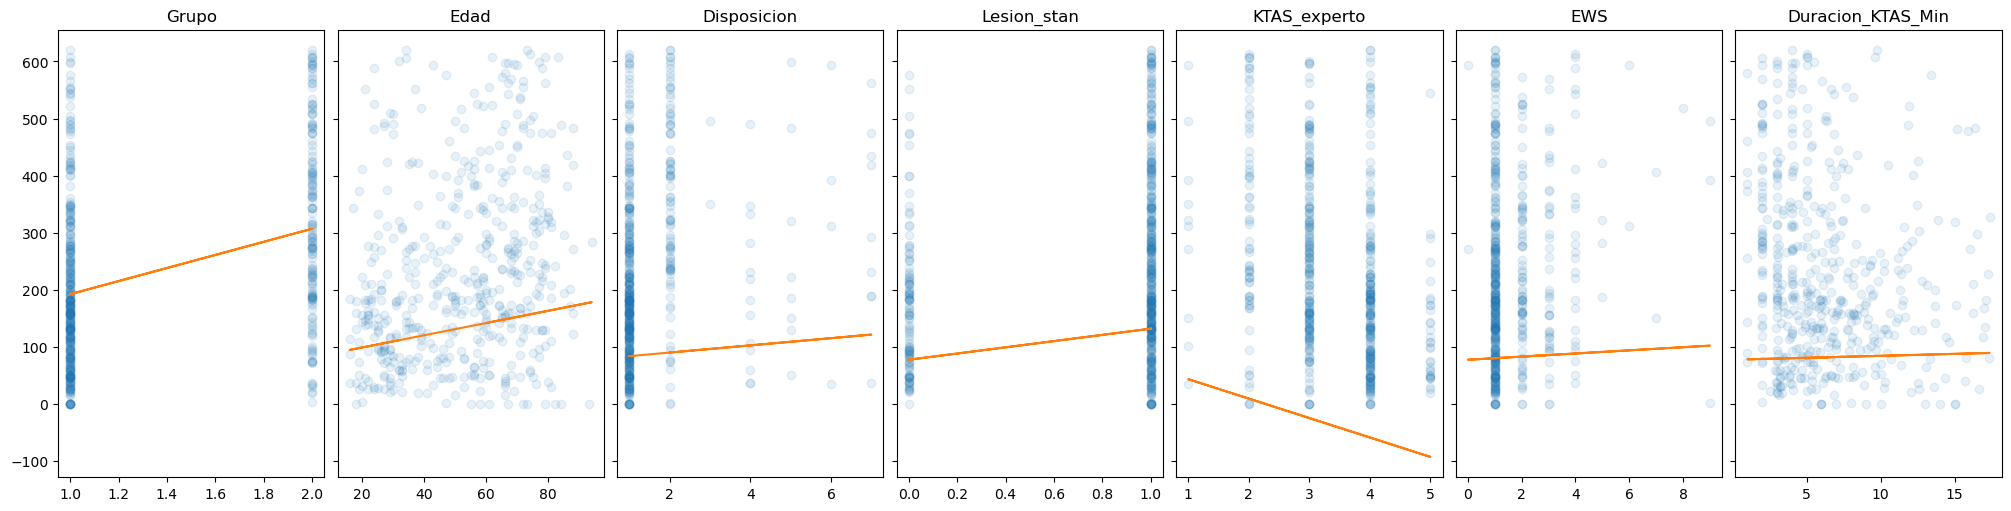

In [386]:
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))


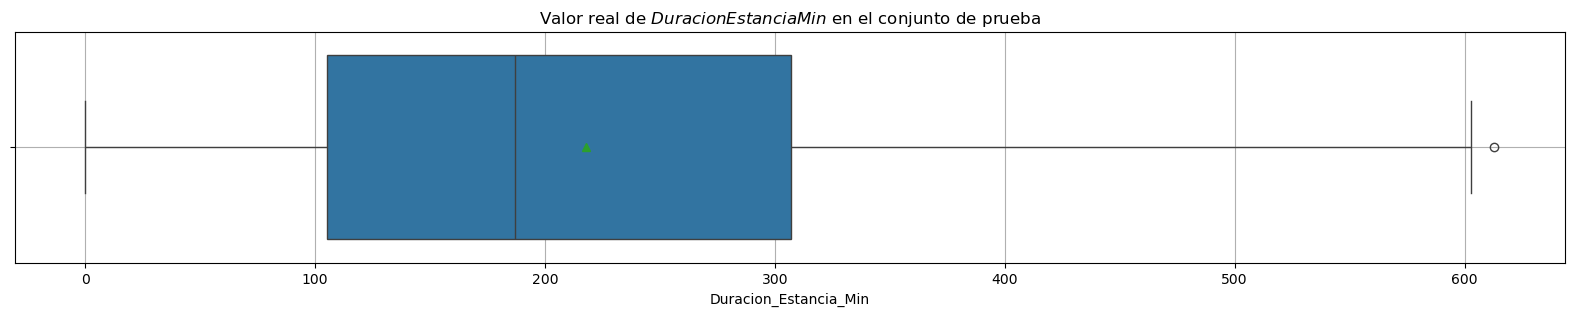

In [387]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Duracion Estancia Min}$ en el conjunto de prueba")
plt.grid()
plt.show()

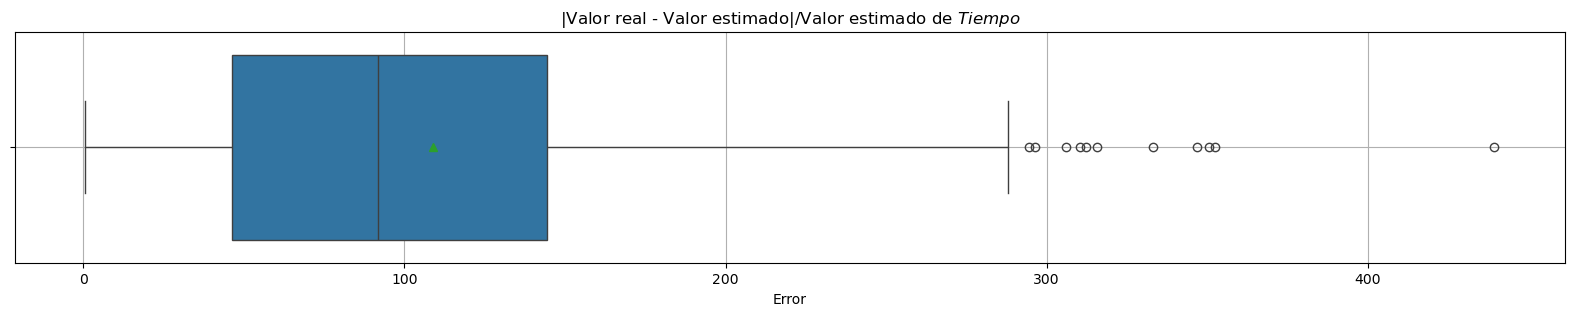

In [388]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado|/Valor estimado de $\t{Tiempo}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [389]:
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})

,columns,coef
0,Grupo,114.77
1,Edad,1.07
2,Disposicion,6.30
3,Lesion_stan,54.47
4,KTAS_experto,-34.04
5,EWS,2.75
6,Duracion_KTAS_Min,0.69


## 5.1 Validación de supuestos

Entre los supuestos del análisis era que:
- Debido a la convención del KTAS (entre más leve la emergencia mayor el KTAS), este tendría un coeficiente negativo con respecto a la duración del paciente en el hospital. Además de esto, podemos ver que el KTAS dado por el experto es un poco más significativo y útil que el dado por la enfermera.

- Entre más edad tiene el paciente mayor va a ser el tiempo que dura en el hospital.

- Entre peor sea la disposición de llegada del paciente, también aumenta su duración.

- Entre peor sean sus signos vitales (EWS) más tiempo tomaría su visita al hospital

## 5.2 Interpretación de los coeficientes

El modelo al que llegamos tiene un error cuadrático medio de alrededor de 130 minutos, es decir que hay un margen de error de 130 minutos entre lo que predice el modelo y el valor real que va a demorarse el paciente. Por esta razón, consideramos que el modelo no está listo para ser usado y no es aún una herramienta fiable para calcular la duración de la estancia de los pacientes.

En cuanto a los coeficientes podemos ver el peso que tienen cada una de estas variables en el tiempo de estadía del paciente:

- Grupo, en la cual un "aumento" de grupo implica un aumento de 118 minutos.

- Edad, cada año adicional del paciente implica 1 minuto adicional de espera, lo cual puede no verse como mucho, pero teniendo en cuenta que el 75% de los pacientes están sobre los 70 años, esto vuelve a la edad muy significativa.

- Disposición, el resultado de su proceso de urgencias significa 6 minutos adicionales, entre peor se considere (6 minutos para un alta a domicilio, mientras que la cirugía implica 42 minutos adicionales).

- Lesión, que el paciente tenga o no una lesión, implica que alrededor de 54 minutos de espera adicional.

- KTAS experto, cada aumento en la escala de KTAS implica menos severidad en la emergencia, lo que se traduce en 34 minutos menos de duracion en el hospital.

- EWS, el EWS es un compilado de los signos vitales y revisa si están en orden o son una, existe una amenaza para la salud del paciente, cada amenaza puede subir entre 1 y 3 puntos el EWS y cada uno de esos puntos implica 3 minutos más en la duracion.

- Duración KTAS en minutos, cada minuto de evaluación KTAS implica 40 segundos de duración adicional en la consulta. (va de 0 a 20, entonces a lo sumo implica 13.6 minutos adicionales).

## 7. Pipeline

Para la exportación del modelo definimos funciones de trasnformación que son los pasos que deben seguir los datos de entreada para que el modelo prueda procesarlo.

En la funcion de transformación objetivos de elijen las variables que se aplicarán en el modelo de regresión.

In [390]:
         
def objetivos(X):
    X = X.copy()
    candidatas = ["grupo", "edad", "disposicion", "lesion_stan","ktas_experto","ews", "duracion_ktas_min"]
    return X[candidatas]


En la funcion de transformación limpieza se comprueba el estado de las variables de interes:
- Valores nulos: De serlo se rellena con el valor mas frecuente segun el entrenamiento
- Tipos de datos: Debes ser de tipo numerico int o float

Posterior se aplica la estarización mencioanda en la preparación de los datos.

Por ultimo se ponen todas las llaves un minuscula para evitar errores.

In [391]:

def limpieza(X):
    X.copy()
    
    X.columns = [col.lower() for col in X.columns]
    
    X['grupo'] = X['grupo'].fillna(0).astype(int)
    
    X['ktas_experto'] = X['ktas_experto'].fillna(0).astype(int)
    
    X['edad'] = X['edad'].fillna(0).astype(int)
    
    X['disposicion'] = X['disposicion'].fillna(0).astype(int)
    
    X['lesion'] = X['lesion'].fillna(0).astype(int)
    X["lesion_stan"] = X["lesion"].apply(lambda x:0 if x == 2 else x)
        
    if X["duracion_ktas_min"].dtype == 'object': 
        X["duracion_ktas_min"] = X["duracion_ktas_min"].str.replace(',', '.').astype('float64')
    elif X["duracion_ktas_min"].dtype not in ['float64', 'int64']:  
        X["duracion_ktas_min"] = pd.to_numeric(X["duracion_ktas_min"], errors='coerce').fillna(0)
    
    
    return X


Se agrupan las variables como signos vitales en un paso adicional.

In [392]:
def calcular_EWS_pipe(registro):
    total = 0
    
    # Frecuencia respiratoria (rr)
    if registro.get('rr', np.nan) <= 8:
        total += 2
    elif 9 <= registro.get('rr', np.nan) <= 14:
        total += 0
    elif 15 <= registro.get('rr', np.nan) <= 20:
        total += 1
    elif 21 <= registro.get('rr', np.nan) <= 29:
        total += 2
    elif registro.get('rr', np.nan) >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro.get('sbp', np.nan) <= 70:
        total += 3
    elif 71 <= registro.get('sbp', np.nan) <= 80:
        total += 2
    elif 81 <= registro.get('sbp', np.nan) <= 100:
        total += 1
    elif 101 <= registro.get('sbp', np.nan) <= 199:
        total += 0
    elif registro.get('sbp', np.nan) >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro.get('hr', np.nan) <= 40:
        total += 2
    elif 41 <= registro.get('hr', np.nan) <= 50:
        total += 1
    elif 51 <= registro.get('hr', np.nan) <= 100:
        total += 0
    elif 101 <= registro.get('hr', np.nan) <= 110:
        total += 1
    elif 111 <= registro.get('hr', np.nan) <= 129:
        total += 2
    elif registro.get('hr', np.nan) >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro.get('bt', np.nan) < 35.0:
        total += 2
    elif 35.0 <= registro.get('bt', np.nan) <= 38.4:
        total += 0
    elif registro.get('bt', np.nan) >= 38.5:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro.get('saturacion', np.nan) <= 91:
        total += 3
    elif 92 <= registro.get('saturacion', np.nan) <= 93:
        total += 2
    elif 94 <= registro.get('saturacion', np.nan) <= 95:
        total += 1

    # Nivel de conciencia
    if registro.get('estado_mental', np.nan) == 1:
        total += 0
    elif registro.get('estado_mental', np.nan) == 2:
        total += 1
    elif registro.get('estado_mental', np.nan) == 3:
        total += 2
    elif registro.get('estado_mental', np.nan) == 4:
        total += 3

    return total

def agrupar_signos_vitales(X):
        X.copy()
        X['ews'] = X.apply(calcular_EWS_pipe, axis=1)
        return X

Se ordenan las intrucciones en el pipe line. La ultima instrucción "Regresión" corresponde a la linealización de los datos.

In [393]:
X_train, X_test, y_train, y_test = train_test_split(datos_recorte, datos_recorte["Duracion_Estancia_Min"], test_size=0.3, random_state=1)

# Crear el pipeline
pipe = Pipeline([
    ('limpieza', FunctionTransformer(limpieza, validate=False)),
    ('Agrupacion', FunctionTransformer(agrupar_signos_vitales, validate=False)),
    ('objetivo', FunctionTransformer(objetivos, validate=False)),
    ('Regresion', LinearRegression())
])

# Entrenar el pipeline
pipe.fit(X_train, y_train).score(X_test, y_test)


0.14955857683649676

Una vez armado y entrenado el modelo, se guarda en el archivo "modelo_regresion_MediAlpes" para su posterior utilización.

In [394]:
dump(pipe, 'modelo_regresion_MediAlpes.pkl', compress=3)
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


A continuacion se muestra un ejemplo de carga y ejecución del modelo

In [395]:
candidatas = ["grupo", "lesion_stan","ktas_experto","ews", "duracion_ktas_min"]
registro_prueba = datos_recorte.sample(1)
modelo_cargado = load('modelo_regresion_MediAlpes.pkl')
y_pred = modelo_cargado.predict(registro_prueba)
print(f"Para el registro\n{registro_prueba[candidatas]}\n. Se estima una duración de la estancia de {y_pred} minutos")

Para el registro
     grupo  lesion_stan  ktas_experto  ews  duracion_ktas_min
457      1            0             4    1              11.68
. Se estima una duración de la estancia de [90.30770396] minutos


## 8. Generar predicciones

Para realizar las prediciones con el modelo generado se cargan los datos y el modelo.

In [396]:
datos_sin_etiquetas = pd.read_csv("./data/Regresión_validation_data.csv")
modelo = load('modelo_regresion_MediAlpes.pkl')

Se aplica el modelo a los datos sin etiqueta.

In [397]:
Duracion_Est_min_prediccion = modelo.predict(datos_sin_etiquetas)
Duracion_Est_min_prediccion

array([260.66253481, 329.99512215, 393.69939012, 316.78492993,
       182.16301588, 164.44187456, 340.73467856, 430.49779825,
       127.01757235, 102.10703138, 363.26066727, 244.32960676,
       349.70232246, 166.89556332, 136.02150584, 213.24137554,
       163.09808266, 268.901269  , 231.68279295, 266.52420865,
       374.91736495, 322.39531953, 203.18580221, 239.49595593,
       217.52668057, 333.96534437, 380.93441087, 348.15666863,
       206.62468795, 194.77283246, 391.64033632, 357.48136523,
       185.80479419, 235.15333052, 314.30411135, 226.12468383,
       355.22266539, 236.65980873, 357.6150566 , 167.60510525,
       123.78586082, 319.01693503, 366.24936308, 184.92203492,
       342.63334624,  98.93217222, 239.85149511, 189.10200723,
       326.01699478, 213.28649287, 243.51253993, 362.96063086,
       375.51704337, 261.16154448, 177.39759374, 232.75545908,
       329.37464345, 182.02466348, 243.52623477, 147.08556747,
       349.70232246, 211.74418817, 235.17547729, 298.91

Se unen las predicciones con los datos sin entiqueta.

In [398]:
datos_predicion = pd.concat([datos_sin_etiquetas, pd.Series(Duracion_Est_min_prediccion, name = "Duracion_Estancia_Min")], axis = 1)
datos_predicion

,grupo,sexo,edad,modo_llegada,lesion,queja_principal,estado_mental,dolor,dolor_nrs,sbp,...,diagnostico_en_urgencias,disposicion,grupo_de_error,duracion_ktas_min,error_triaje,ktas_enfermera,ktas_experto,lesion_stan,ews,Duracion_Estancia_Min
0,2,1,41,3,2,Open Wound,1,1,3,120.00,...,"Superficial injury of face NOS, contusion",1,0,4.00,0,3,3,0,1,260.66
1,1,1,63,2,1,arrest,4,0,#BOÞ!,NaN,...,Cardiac arrest,6,0,5.42,0,1,1,1,3,330.00
2,2,2,76,2,1,dyspnea,1,1,3,110.00,...,"Heart failure, unspecified",2,0,5.00,0,2,2,1,1,393.70
3,2,1,73,4,1,fever,1,0,#BOÞ!,100.00,...,"Fever, unspecified",1,0,2.00,0,4,4,1,2,316.78
4,1,1,24,3,1,Near syncope,1,0,#BOÞ!,139.00,...,Syncope,1,0,4.05,0,3,3,1,1,182.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,2,62,3,1,dyspnea,1,1,3,110.00,...,"Atrial fibrillation and atrial flutter, unspec...",2,0,4.00,0,2,2,1,1,378.00
296,1,2,56,3,1,RLQ abd. pain,1,1,4,163.00,...,Acute appendicitis,5,0,5.75,0,3,3,1,1,242.84
297,2,2,48,2,1,right chest pain,1,1,5,120.00,...,Unstable angina,1,0,4.00,0,2,2,1,1,356.68
298,2,1,29,3,2,foreign body ingestion,1,1,6,140.00,...,Chronic sore throat,1,0,5.00,0,3,3,0,1,248.48


Se guarda en un archivo los resultados de las predicciones con la llave "Duracion_Estancia_Min"

In [399]:
datos_predicion.to_csv("./data/Regresión_predict_data.csv", sep=',', index=False, encoding='utf-8')

## Procesamiento de texto

Para el procesamiento de texto contamos con 714 registros en lenguaje natural que contienen la queja o la razon por la que las personas fueron aurgencias

In [400]:
datos_recorte['Queja_Principal'].info()

<class 'pandas.core.series.Series'>
Index: 714 entries, 1 to 965
Series name: Queja_Principal
Non-Null Count  Dtype 
--------------  ----- 
714 non-null    object
dtypes: object(1)
memory usage: 11.2+ KB


In [401]:
textos = datos_recorte.copy()
textos['Conteo'] = [len(x) for x in textos['Queja_Principal']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Queja_Principal']]
textos[["Queja_Principal", "Conteo", "Max",	"Min"]]

,Queja_Principal,Conteo,Max,Min
1,headache,8,8,8
2,ant. chest pain,15,5,4
3,headache,8,8,8
4,fever & chill,13,5,1
6,abd pain,8,4,3
...,...,...,...,...
961,dyspnea,7,7,7
962,dysarthria,10,10,10
963,DZ - Dizziness,14,9,1
964,dysarthria,10,10,10


Definicmos las trasformaciones que se le harán a cada palabra, convertirlas en ascii, ponerlas en minuscula, eliminar puntuación.

In [402]:

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word:  # Verifica que la palabra no sea None o una cadena vacía
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = [word.lower() for word in words if word]  # Usa comprensión de listas
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = [re.sub(r'[^\w\s]', '', word) for word in words if word]  # Usa comprensión de listas
    return [word for word in new_words if word]

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('english'))  # Usa un set para búsquedas más rápidas
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

def preprocessing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [403]:
textos['Queja_Principal'] = textos['Queja_Principal'].apply(contractions.fix)

Aplicamos las trasformaciones a cada uno de los registros para limpiar las palabras.

In [404]:
textos['words'] = textos['Queja_Principal'].apply(lambda x: preprocessing(word_tokenize(x)))
textos['words1']= textos['words'].apply(preprocessing)
textos['words'] = textos['words1'].apply(lambda x: ' '.join(map(str, x)))
textos['words'].dropna()

textos.head()


,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Error_Triaje,Sexo_stan,Lesion_stan,EWS,Dur_KTAS_lin,Conteo,Max,Min,words,words1
1,2,2,30,4,1,headache,1,1,4,140.00,...,0,0,1,1,1.10,8,8,8,headache,[headache]
2,2,1,61,3,2,ant. chest pain,1,1,3,100.00,...,0,1,0,2,0.69,15,5,4,ant chest pain,"[ant, chest, pain]"
3,2,2,61,3,1,headache,1,1,4,120.00,...,2,0,1,1,0.69,8,8,8,headache,[headache]
4,1,2,67,3,1,fever & chill,1,0,0,143.00,...,2,0,1,4,1.28,13,5,1,fever chill,"[fever, chill]"
6,1,1,74,3,1,abd pain,1,1,6,118.00,...,0,1,1,1,2.17,8,4,3,abd pain,"[abd, pain]"


In [405]:
X_data, y_data = textos['words'], textos['Duracion_Estancia_Min']

Se crea una matriz que indica si un termino aparece o no en un registro.

In [406]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_data) 
print(X_dummy.shape)

X_dense = X_dummy.toarray()
X_df = pd.DataFrame(X_dense, columns=dummy.get_feature_names_out())
X_df


(714, 249)


,abd,abdomen,abdominal,abnormal,abuse,activity,acuity,acute,adult,alcohol,...,visual,voice,voiding,vomiting,wall,weakness,whirling,wound,wrist,wyou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora normalizamos cada uno de los vectores para que reflejen la frecuencia en la que aprecen

In [407]:
tt = TfidfTransformer(norm='l2', use_idf=True)
tt_matrix = tt.fit_transform(X_dummy)


Se crea una matriz con estos pesos

In [408]:

tt_matrix_dense = tt_matrix.toarray()
vocab = dummy.get_feature_names_out()
tt_df = pd.DataFrame(np.round(tt_matrix_dense, 2), columns=vocab)
tt_df


,abd,abdomen,abdominal,abnormal,abuse,activity,acuity,acute,adult,alcohol,...,visual,voice,voiding,vomiting,wall,weakness,whirling,wound,wrist,wyou
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
710,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
711,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
712,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Ahora se construye una matriz de frecuencias de cada palabra en todos los registros

In [409]:
import scipy.sparse as sp
feature_names = list(tt_df.columns)
# build the document frequency matrix
df = np.diff(sp.csc_matrix(tt_df, copy=True).indptr)
df = 1 + df # adding 1 to smoothen idf later
# show smoothened document frequencies
pd.DataFrame([df], columns=feature_names)


,abd,abdomen,abdominal,abnormal,abuse,activity,acuity,acute,adult,alcohol,...,visual,voice,voiding,vomiting,wall,weakness,whirling,wound,wrist,wyou
0,59,7,16,2,2,2,2,6,2,2,...,3,2,8,12,3,23,3,21,7,2


Ahora se establece la frecuencia inversa de cada palabra

In [410]:

# compute inverse document frequencies
total_docs = 1 + len(vocab)
idf = 1.0 + np.log(float(total_docs) / df)
# show smoothened idfs
pd.DataFrame([np.round(idf, 2)], columns=feature_names)


,abd,abdomen,abdominal,abnormal,abuse,activity,acuity,acute,adult,alcohol,...,visual,voice,voiding,vomiting,wall,weakness,whirling,wound,wrist,wyou
0,2.44,4.58,3.75,5.83,5.83,5.83,5.83,4.73,5.83,5.83,...,5.42,5.83,4.44,4.04,5.42,3.39,5.42,3.48,4.58,5.83


Se crea una matriz diagonal con las frecuencias inversas

In [411]:
# compute idf diagonal matrix
total_features = tt_df.shape[1]
idf_diag = sp.spdiags(idf, diags=0, m=total_features, n=total_features)
idf_dense = idf_diag.todense()
# print the idf diagonal matrix
pd.DataFrame(np.round(idf_dense, 2))

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,2.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,4.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,3.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,5.83,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,5.83,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,3.39,0.00,0.00,0.00,0.00
245,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,5.42,0.00,0.00,0.00
246,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.48,0.00,0.00
247,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.58,0.00


Se multiplica la matriz de las frecuencias inversas con los vectores de cada registro

In [412]:
# compute tfidf feature matrix
tf = np.array(tt_df, dtype="float64")
tfidf = tf * idf
# view raw tfidf feature matrix
tfidf = pd.DataFrame(np.round(tfidf, 2), columns=feature_names)
tfidf


,abd,abdomen,abdominal,abnormal,abuse,activity,acuity,acute,adult,alcohol,...,visual,voice,voiding,vomiting,wall,weakness,whirling,wound,wrist,wyou
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
710,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
711,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
712,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Para el entrenamiendo usamos cada uno de los vectores que representan el registro y el tiempo de estancia.

In [413]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, y_data, test_size=0.3, random_state=42)

In [414]:
regressor = LinearRegression()

# Entrenar el modelo
regressor.fit(X_train, y_train)

LinearRegression()

In [415]:
print("Train:", np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

Train: 132.78154373005964
Test: 1.740274692433763e+16


Hacemos una regreción lineal con los vectores y podemos ver los coeficientes de cuanto se relaciona una queja con los minutos que dura la persona

In [416]:
pd.options.display.float_format = '{:.2f}'.format
pd.DataFrame({"columns": feature_names, "coef": np.round(regressor.coef_, 1)}).sort_values(by="columns")

,columns,coef
0,abd,79.00
1,abdomen,12.90
2,abdominal,66.40
3,abnormal,-2572523988985443.00
4,abuse,9770350535686572.00
...,...,...
244,weakness,126.50
245,whirling,-213954038395436.91
246,wound,-40.00
247,wrist,7.50
